In [366]:
import argparse
import pandas as pd
import numpy as np
import os 

from matplotlib import pyplot as plt

In [429]:
input_path = "./data/raw/2023_set_n1/2023_01_04-00_16_30.csv"
df = pd.read_csv(input_path)
freq = [x for x in df.columns if "CL" in x]
data = df[freq].to_numpy()
time = 0.02 * np.arange(data.shape[0])


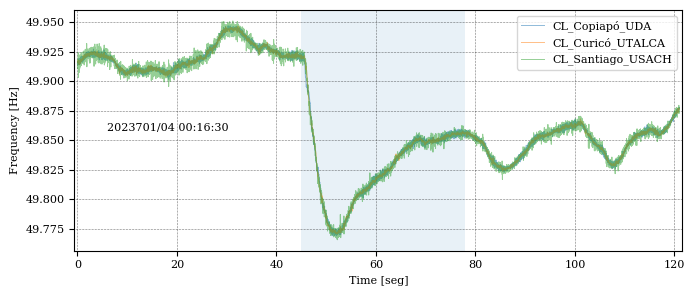

In [443]:
font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)
plt.rcParams['axes.xmargin'] = .005

fig = plt.figure(figsize=(7,3))

t0 = 45
tm = 78
plt.axvspan(t0, tm, alpha=.1)

plt.grid(color='k', linestyle='dotted', linewidth=.4)

plt.plot(time, data, alpha=.5, linewidth=.7)
#plt.title("2023/01/04 16:30")
plt.annotate("2023701/04 00:16:30", xy = (6,49.858))

plt.xlabel("Time [seg]")
plt.ylabel("Frequency [Hz]")



plt.legend(freq)

#plt.text( 60.5, 49.815, 'Identification\nInterval', alpha=.3)

fig.tight_layout()

plt.savefig('./img/DataExample.pdf')

In [367]:
import pickle
from scipy import signal

import sys
sys.path.insert(0, ".")
sys.path.insert(0, "./src/")
import models as mdl

In [179]:
## run sumplers and identifications for E1a 
instance = "2023_01_05-00_21_20"
et = 15
model = "B2"
for i in range(10):
    et = et + 5
    sam_dir = f"test/test_interval_exp_paper/{et}"
    parameters = "30,0.56261,0.74232"
    if not os.path.isdir(sam_dir):
                os.makedirs(sam_dir)

    os.system(f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {sam_dir} -et {et}")
    for rep in range(11):
        out_dir = f"{sam_dir}/rep{rep}"
        if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
        os.system(f"python src/de_run.py -i {sam_dir}/{instance}_sampled.csv -o {out_dir} -m {model} -p {parameters}")

------------------------------------------------------------------------------------
   input: 2023_01_05-00_21_20_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0004686363413788175
       x: [ 4.773e+02  7.980e+02  2.442e+01  8.502e-01  8.169e+00]
     nit: 63
    nfev: 9600
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
   input: 2023_01_05-00_21_20_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.00046846733112647945
       x: [ 4.343e+02  7.311e+02  2.431e+01  8.539e-01 

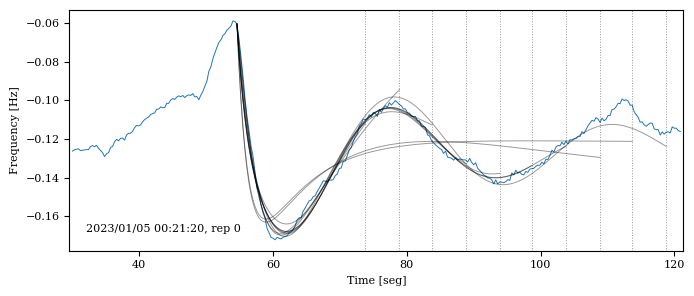

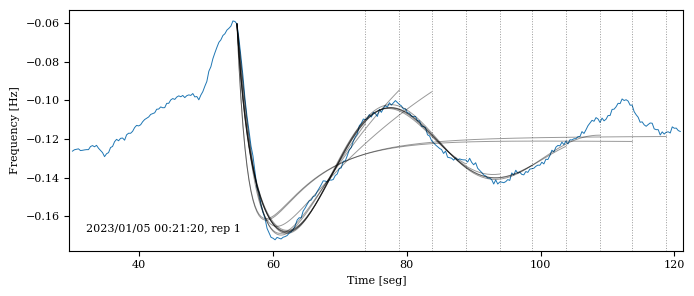

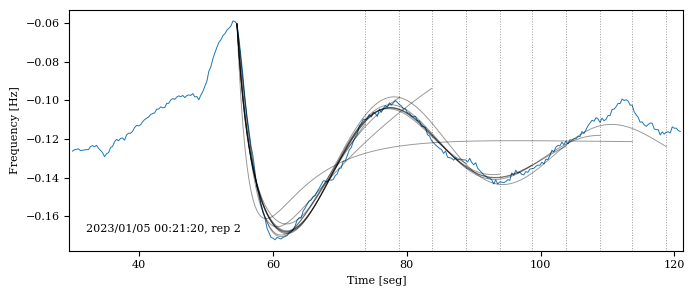

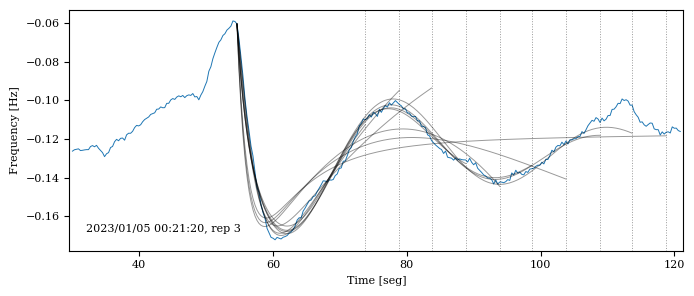

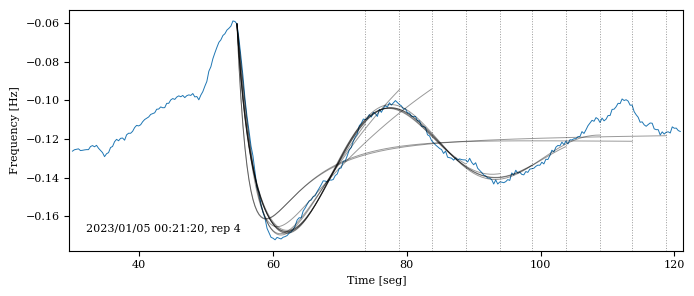

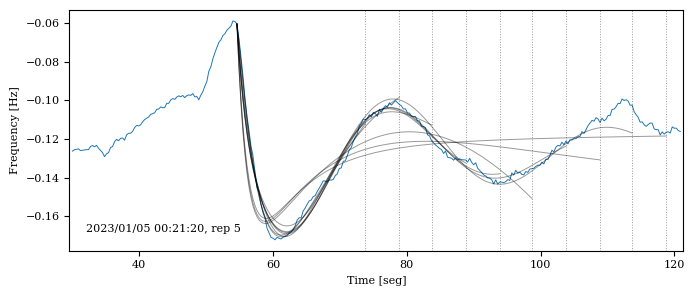

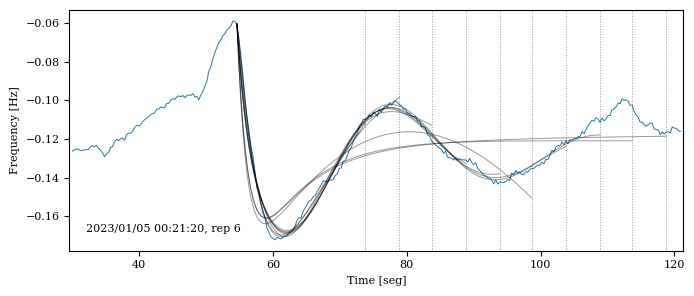

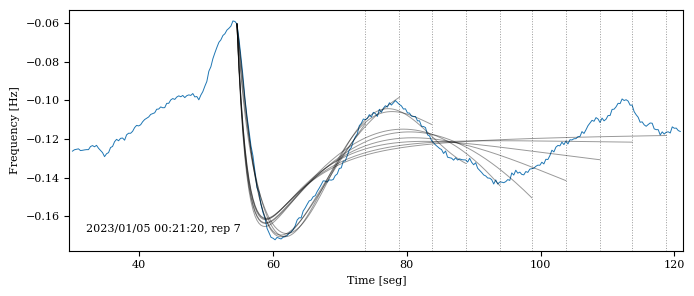

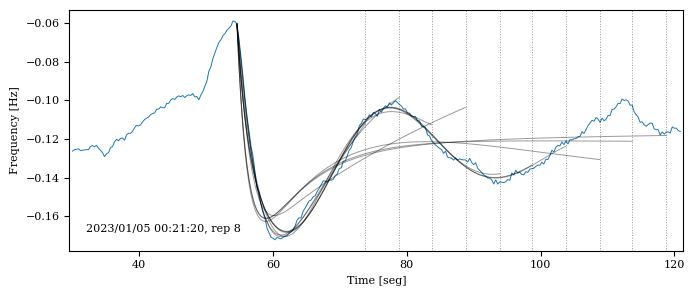

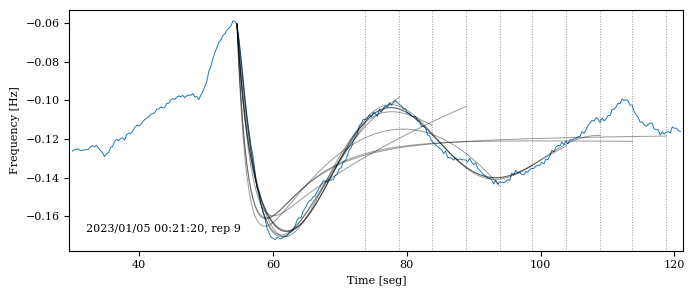

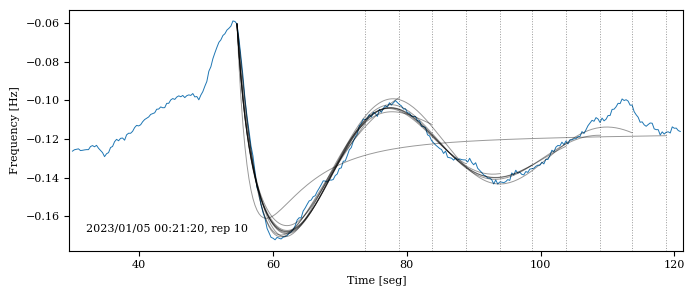

In [453]:
## Fig1 E1a

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

model = "B2"

for rep in range(11):
    et = 15
    for i in range(10):
        et = et + 5
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}"
        
        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        x = result.x
        df = pd.read_csv(f"{sam_dir}/{instance}_sampled.csv")  
        Ts = df["time"][1]
        P0 = -df["power"][0] / 1000
        event_freq = df["delta_freq"][df["event"]==1].to_numpy()

        if model == "b":
            sys = mdl.modelo_b(x, Ts)
        elif model == "c":
            sys = mdl.modelo_c(x, Ts)
        elif model == "cc":
            sys = mdl.modelo_cc(x, Ts)
            ########################################
        elif model == "A1":
            sys = mdl.modelo_A1(x, Ts)
        elif model == "A2":
            sys = mdl.modelo_A2(x, Ts)
        elif model == "B1":
            sys = mdl.modelo_B1(x, Ts)
        elif model == "B2":
            sys = mdl.modelo_B2(x, Ts)

        sim_power = P0 * np.repeat(1, event_freq.shape)
        sim = signal.dlsim(sys, sim_power, x0 = event_freq[0])
        sim_freq = sim[1].ravel()

        real_time = df["time"].to_numpy()
        real_freq = df["delta_freq"].to_numpy()

        event_time = df["time"][df["event"]==1].to_numpy()

        sim_time = np.linspace(event_time[0],event_time[-1],num=sim_freq.size)

        if i == 0:
            fig = plt.figure(figsize=(7,3))
            plt.plot(real_time[100:], real_freq[100:], linewidth=.7)
            #plt.title(f"2023/01/05 21:20 rep{rep}")
            plt.annotate(f"2023/01/05 00:21:20, rep {rep}", xy = (32,-.168))
            plt.xlabel("Time [seg]")
            plt.ylabel("Frequency [Hz]")


        plt.plot(sim_time,sim_freq, alpha=.4, linewidth=.7, color = "k")
        plt.axvline(sim_time[-1], alpha=.4, linewidth=.7, color = "k", linestyle='dotted')

    fig.tight_layout()
    plt.savefig(f"./img/ExpIntervalSims{rep}.pdf")

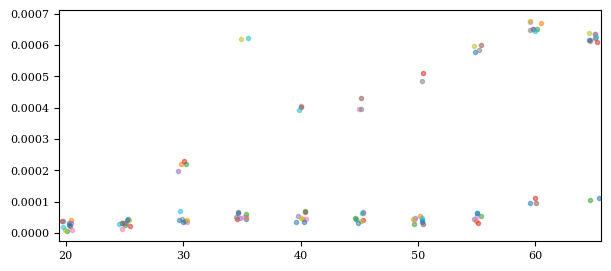

In [455]:
## Save this idea for E3

instance = "2023_01_05-00_21_20"

ERR = []
et = 15

ETS = [et + 5*(i+1) for i in range(10)]

for i in range(10):
    et = et + 5
    err = []    
    for rep in range(11):
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}"

        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        err.append(result.fun/et)
    ERR.append(err)
    
fig = plt.figure(figsize=(7,3))


for rep in range(11):
    jitterETS = ETS.copy()
    jitterERR = [ERR[i][rep] for i in range(10)]
    for i in range(10):
        jitterETS[i] = jitterETS[i] + .5*(2*np.random.rand()-1)
        jitterERR[i] = jitterERR[i] + .00002*(2*np.random.rand()-1)
        
    plt.plot(jitterETS, jitterERR, marker = ".", linestyle="", alpha = .5)
plt.show()

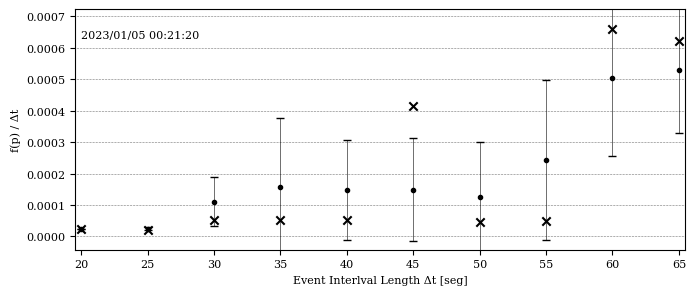

In [456]:
## fig2 E1a

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

fig = plt.figure(figsize=(7,3))
rep = 6
err = [ERR[i][rep] for i in range(10)]


npERR = np.array(ERR)
err_means = [npERR[i].mean() for i in range(10)]
err_sd = [npERR[i].std() for i in range(10)]
plt.errorbar(ETS, err_means, err_sd, color='k', linewidth=.4, linestyle='None', marker='.', capsize=3)

plt.scatter(ETS, err, color = "k", marker = "x")
#plt.title("2023/01/04 16:30")
#plt.title("2023/01/05 21:20")

plt.annotate("2023/01/05 00:21:20", xy = (20,0.00063))

plt.xlabel("Event Interlval Length Δt [seg]")
plt.ylabel("f(p) / Δt")
plt.grid(axis = 'y', color='k', linestyle='dotted', linewidth=.4)
fig.tight_layout()

d=.1*(max(err)-min(err))
plt.ylim([min(err)-d,max(err)+d])
plt.xticks(ETS)
fig.tight_layout()



plt.savefig(f"./img/ExpIntervalErrs{rep}.pdf")
plt.show()

In [368]:
## run identifications for E1b Con True en use_emp
instance = "2023_01_05-00_21_20"
et = 15
model = "B2"
for i in range(10):
    et = et + 5
    sam_dir = f"test/test_interval_exp_paper/{et}"
    parameters = "30,0.56261,0.74232"

    for rep in range(11):
        out_dir = f"{sam_dir}/rep{rep}emp"
        if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
        os.system(f"python src/de_run.py -i {sam_dir}/{instance}_sampled.csv -o {out_dir} -m {model} -p {parameters}")


hat_K = 84.26305750790377
hat_H = 3.3705223003161504

hat_Kd = 0.7425483438905432

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.03370522300316153, 6.70733937762914), (0.222764503167163, 1.2623321846139235)]

------------------------------------------------------------------------------------
   input: 2023_01_05-00_21_20_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.00046331334415837305
       x: [ 3.921e+01  6.836e+01  1.387e+01  8.925e-01  1.246e+00]
     nit: 110
    nfev: 16650
------------------------------------------------------------------------------------

hat_K = 84.26305750790377
hat_H = 3.3705223003161504

hat_Kd = 0.7425483438905432

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.03370522300316153, 6.70733937762914), (0.222764503167163, 1.26233218461

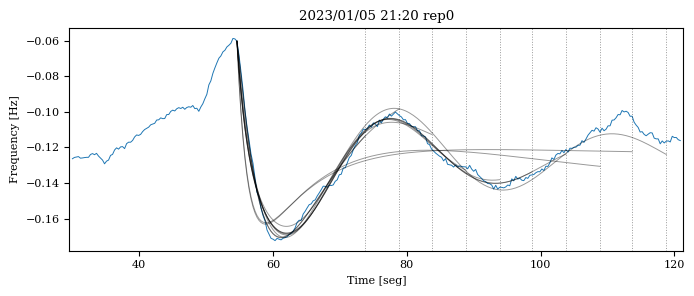

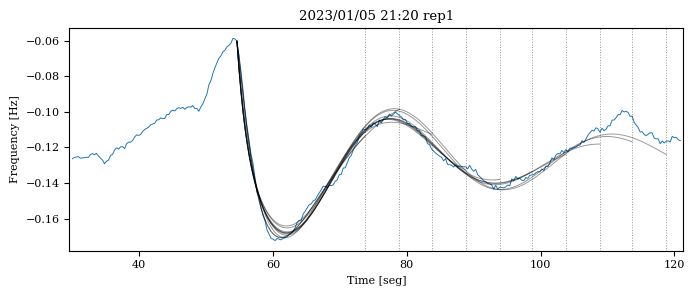

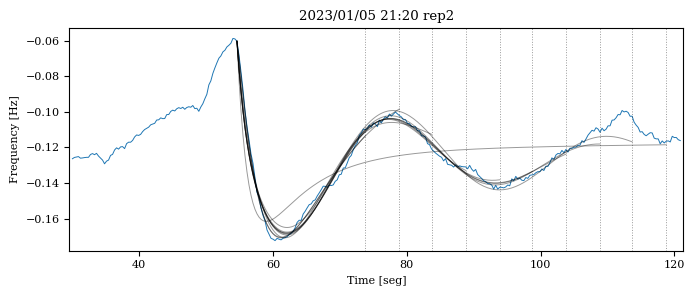

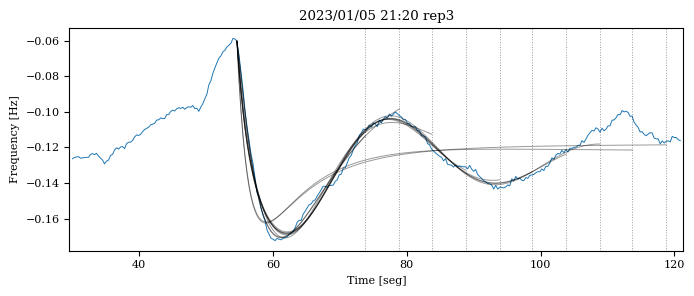

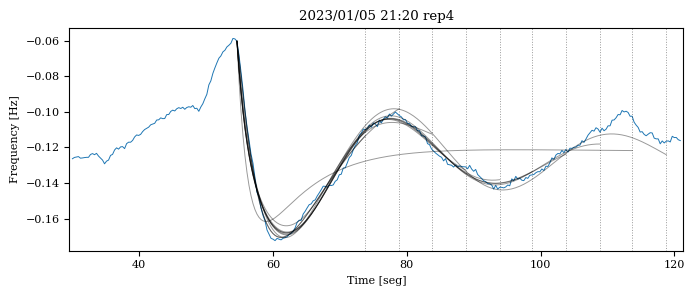

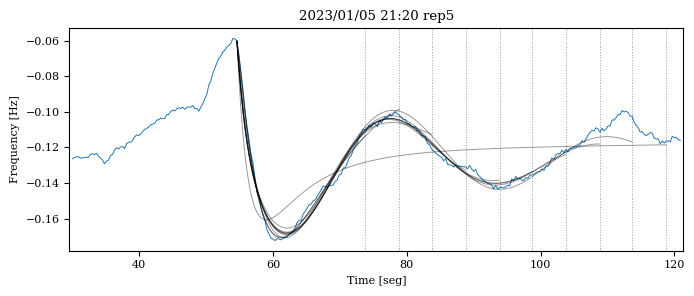

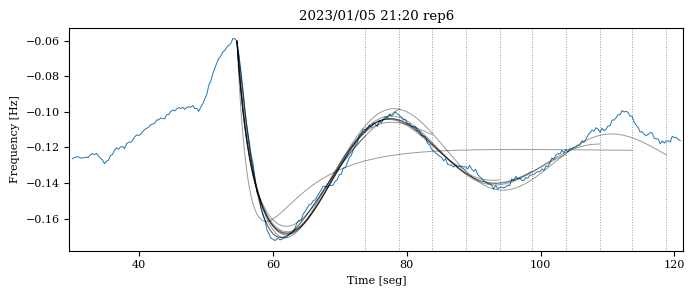

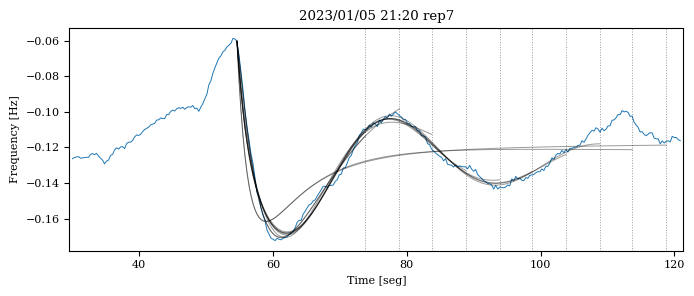

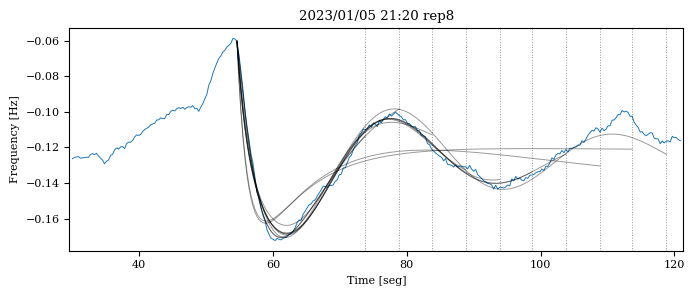

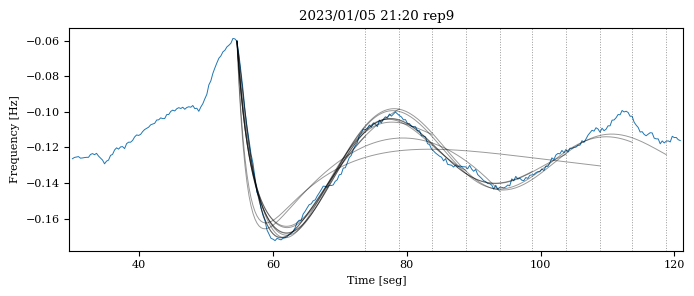

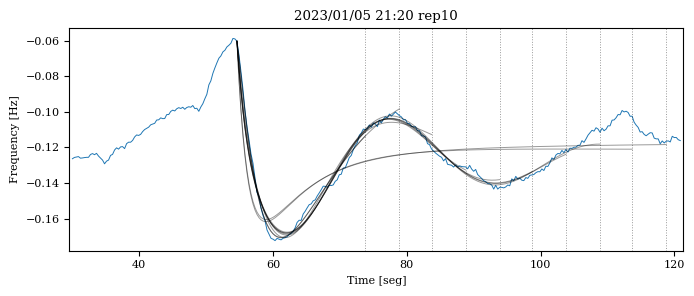

In [369]:
## Fig1 E1b

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

model = "B2"

for rep in range(11):
    et = 15
    for i in range(10):
        et = et + 5
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}emp"
        
        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        x = result.x
        df = pd.read_csv(f"{sam_dir}/{instance}_sampled.csv")  
        Ts = df["time"][1]
        P0 = -df["power"][0] / 1000
        event_freq = df["delta_freq"][df["event"]==1].to_numpy()

        if model == "b":
            sys = mdl.modelo_b(x, Ts)
        elif model == "c":
            sys = mdl.modelo_c(x, Ts)
        elif model == "cc":
            sys = mdl.modelo_cc(x, Ts)
            ########################################
        elif model == "A1":
            sys = mdl.modelo_A1(x, Ts)
        elif model == "A2":
            sys = mdl.modelo_A2(x, Ts)
        elif model == "B1":
            sys = mdl.modelo_B1(x, Ts)
        elif model == "B2":
            sys = mdl.modelo_B2(x, Ts)

        sim_power = P0 * np.repeat(1, event_freq.shape)
        sim = signal.dlsim(sys, sim_power, x0 = event_freq[0])
        sim_freq = sim[1].ravel()

        real_time = df["time"].to_numpy()
        real_freq = df["delta_freq"].to_numpy()

        event_time = df["time"][df["event"]==1].to_numpy()

        sim_time = np.linspace(event_time[0],event_time[-1],num=sim_freq.size)

        if i == 0:
            fig = plt.figure(figsize=(7,3))
            plt.plot(real_time[100:], real_freq[100:], linewidth=.7)
            plt.title(f"2023/01/05 21:20 rep{rep}")
            plt.xlabel("Time [seg]")
            plt.ylabel("Frequency [Hz]")


        plt.plot(sim_time,sim_freq, alpha=.4, linewidth=.7, color = "k")
        plt.axvline(sim_time[-1], alpha=.4, linewidth=.7, color = "k", linestyle='dotted')

    fig.tight_layout()
    plt.savefig(f"./img/ExpIntervalSims{rep}emp.pdf")

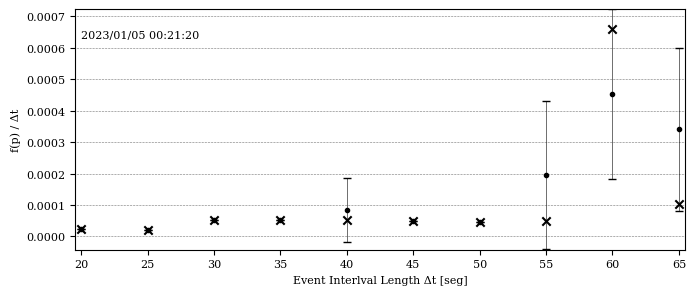

In [426]:
## fig2 E1b

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

ERR = []
et = 15

ETS = [et + 5*(i+1) for i in range(10)]

for i in range(10):
    et = et + 5
    err = []    
    for rep in range(11):
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}emp"

        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        err.append(result.fun/et)
    ERR.append(err)


fig = plt.figure(figsize=(7,3))
rep = 6
err = [ERR[i][rep] for i in range(10)]


npERR = np.array(ERR)
err_means = [npERR[i].mean() for i in range(10)]
err_sd = [npERR[i].std() for i in range(10)]
plt.errorbar(ETS, err_means, err_sd, color='k', linewidth=.4, linestyle='None', marker='.', capsize=3)

plt.scatter(ETS, err, color = "k", marker = "x")
#plt.title("2023/01/04 16:30")
#plt.title("2023/01/05 21:20")

plt.annotate("2023/01/05 00:21:20", xy = (20,0.00063))

plt.xlabel("Event Interlval Length Δt [seg]")
plt.ylabel("f(p) / Δt")
plt.grid(axis = 'y', color='k', linestyle='dotted', linewidth=.4)
fig.tight_layout()

d=.1*(max(err)-min(err))
plt.ylim([min(err)-d,max(err)+d])
plt.xticks(ETS)
fig.tight_layout()



plt.savefig(f"./img/ExpIntervalErrs{rep}emp.pdf")
plt.show()

In [374]:
import pickle
from scipy import signal

import sys
sys.path.insert(0, ".")
sys.path.insert(0, "./src/")
import models as mdl

In [376]:
## run sumplers for E2

input_dir = "data/raw/2023_set_n1/"
output_dir  = "test/test_models_exp_paper/samps/"
instances = []
with os.scandir(input_dir) as files:
    for file in files:
        if ".csv" in file.name:
            instance, ext = os.path.splitext(file.name)
            instances.append(instance)
            input_path = os.path.join(input_dir, file.name)
            os.system(f"python src/sampler.py -i {input_path} -o {output_dir}")    

In [ ]:
## run identifications E2

for mod in model:
    out_dir = f"test/test_models_exp_paper/{mod}"
    for rep in range(11):
        for ins in instances:
            output_dir = f"{out_dir}/{ins}/rep{rep}"
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            os.system(f"python src/de_run.py -i {sam_dir}/{ins}_sampled.csv -o {output_dir} -m {mod} -p {parameters}")

In [414]:
## load E2 results

model = ["A1","A2","B1","B2"]
res_dir  = "test/test_models_exp_paper/"

INS = []
REP = []
MOD = []

for mod in model:
    for rep in range(11):
        for ins in instances:
            INS.append(ins)
            REP.append(rep)
            MOD.append(mod)
data = {'ins': INS, 'rep': REP, 'model': MOD}
df = pd.DataFrame(data)

FUN = []
SUC = []
NIT = []
NFEV = []

H = []
Kd = []

Ta = [] 
Tb = []
Tc = [] 
Td = []

for i in range(len(df)):
    res_path = os.path.join(res_dir, df.model[i], df.ins[i], f"rep{df.rep[i]}", f"{df.ins[i]}_sampled_result.p")
    file = open(res_path, 'rb')
    result = pickle.load(file)
    file.close()
    FUN.append(result.fun)
    SUC.append(result.success)
    NIT.append(result.nit)
    NFEV.append(result.nfev)
    
    H.append(result.x[-2])
    Kd.append(result.x[-1])
    
    if df.model[i] == "A1":
        Ta.append(result.x[0])
        Tb.append(result.x[1])
        Tc.append(result.x[2])
        Td.append(float("nan"))
    elif df.model[i] == "A2":
        Ta.append(result.x[0])
        Tb.append(result.x[1])
        Tc.append(result.x[2])
        Td.append(result.x[3])
    elif df.model[i] == "B1":
        Ta.append(float("nan"))
        Tb.append(result.x[0])
        Tc.append(result.x[1])
        Td.append(float("nan"))
    elif df.model[i] == "B2":
        Ta.append(float("nan"))
        Tb.append(result.x[0])
        Tc.append(result.x[1])
        Td.append(result.x[2])
    
df['fun'] = FUN
df['success'] = SUC
df['nit'] = NIT
df['nfev'] = NFEV
df['Ta'] = Ta
df['Tb'] = Tb
df['Tc'] = Tc
df['Td'] = Td
                  

print(df.to_string())
df.to_csv("./out/models_experimet_results.csv")


                      ins  rep model         fun  success   nit    nfev          Ta          Tb          Tc          Td
0     2023_02_09-00_13_00    0    A1    0.000271     True   128   19350   15.989357    0.911450    6.289556         NaN
1     2023_02_13-14_08_10    0    A1   15.997274     True     9    1500  767.054230  794.561305   63.324752         NaN
2     2023_01_06-08_45_00    0    A1    0.004543     True   116   17550  703.244025    2.923320   49.061895         NaN
3     2023_01_05-00_21_20    0    A1    0.002259     True    66   10050    4.340125  979.769176  163.122672         NaN
4     2023_01_13-14_04_00    0    A1    0.011018     True    34    5250    4.184630  289.660305  387.773980         NaN
5     2023_02_12-10_41_30    0    A1  469.448733     True    21    3300  721.026214  822.037590    1.093677         NaN
6     2023_02_01-21_45_40    0    A1    0.001261     True    78   11850    9.067305   84.399422  247.052530         NaN
7     2023_02_24-11_33_50    0    A1    

In [409]:
vg = [1,2,3]
try: 
    print(vg[3])
except:
    print("exept")
else:
    print("else")
    
print(result)
result.x[-1]

float("nan")

exept
 message: Optimization terminated successfully.
 success: True
     fun: 0.0019969522639532882
       x: [ 3.365e+00  3.788e+00  2.022e-01  4.787e+00  1.786e+00]
     nit: 92
    nfev: 13950


nan

In [178]:

#instance = "2023_01_05-00_21_20"

instance = "2023_01_04-00_16_30"
output_dir = f"test/test_new_models/"
et = 37

model = "B2"
parameters = "30,0.56261,0.74232"

f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {output_dir} -et {et}"

os.system(f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {output_dir} -et {et}")
os.system(f"python src/de_run.py -i {output_dir}{instance}_sampled.csv -o {output_dir} -m {model} -p {parameters}")



hat_K = 51.53779438254718
hat_H = 2.0615117753018875

hat_Kd = 0.6743430474740779

bounds = [(1e-05, 1000), (1e-05, 1000), (1e-05, 1000), (0.020615117753018893, 4.102408432850756), (0.2023029142422234, 1.1463831807059324)]

------------------------------------------------------------------------------------
   input: 2023_01_04-00_16_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.001760582680079878
       x: [ 1.710e+01  2.704e+01  7.960e+00  7.135e-01  6.995e-01]
     nit: 102
    nfev: 15450
------------------------------------------------------------------------------------


0